# Importing Repositories

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
plt.rcParams['figure.figsize']=(20,10)

# Functions

In [2]:
def missing_zero_values_table(df): 
        zero_val = (df == 0.00).astype(int).sum(axis=0)
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
        columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% of Total Values'})
        mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
        mz_table['% Total Zero Missing Values'] = 100 * mz_table['Total Zero Missing Values'] / len(df)
        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[
            mz_table.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Our selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
            "There are " + str(mz_table.shape[0]) +
              " columns that have missing values.")
    
        return mz_table

# Importing data files

## Paths for files

In [3]:
path_price = r'C:\Users\2836589S\OneDrive - University of Glasgow\Data\DayAheadPrices_12.1.D'
path_totalload = r'C:\Users\2836589S\OneDrive - University of Glasgow\Data\DayAheadTotalLoadForecast'
path_windsolar = r'C:\Users\2836589S\OneDrive - University of Glasgow\Data\DayAheadGenerationForecastForWindAndSolar_14.1.D'

## Price Timeseries Importing

In [4]:

df_price = pd.read_csv(r'C:\Users\2836589S\OneDrive - University of Glasgow\Data\Data Frames\price_timeseries_outliers.csv', 
parse_dates=['DateTime'])


In [5]:
df_price = df_price[['DateTime', 'Year', 'Month','Week', 'Day', 'Hour', 'Price', 'Outlier']]
df_price

,DateTime,Year,Month,Week,Day,Hour,Price,Outlier
0,2015-01-01 00:00:00,2015,1,1,3,0,0.00,N
1,2015-01-01 01:00:00,2015,1,1,3,1,0.00,N
2,2015-01-01 02:00:00,2015,1,1,3,2,0.00,N
3,2015-01-01 03:00:00,2015,1,1,3,3,0.00,N
4,2015-01-01 04:00:00,2015,1,1,3,4,0.00,N
...,...,...,...,...,...,...,...,...
52529,2020-12-31 18:00:00,2020,12,53,3,18,71.30,N
52530,2020-12-31 19:00:00,2020,12,53,3,19,61.04,N
52531,2020-12-31 20:00:00,2020,12,53,3,20,60.39,N
52532,2020-12-31 21:00:00,2020,12,53,3,21,57.96,N


## Wind and Solar Timeseries Importing

In [6]:
f_windsolar = glob.glob(path_windsolar + "/*.csv")
dwindsolar = [pd.read_csv(f, sep='\t', parse_dates=['DateTime']) for f in f_windsolar]

df_windsolar = pd.concat(dwindsolar)
df_windsolar = df_windsolar[df_windsolar['AreaCode'] == '10YGB----------A']
df_windsolar = df_windsolar[['DateTime', 'ProductionType', 'AggregatedGenerationForecast']]
df_windsolar.sort_values(by='DateTime', ascending=True)
df_windsolar.reset_index(drop=True, inplace=True)

In [7]:
df_windsolar

,DateTime,ProductionType,AggregatedGenerationForecast
0,2014-12-30 00:00:00,Solar,0.00
1,2014-12-30 01:00:00,Solar,0.00
2,2014-12-30 02:00:00,Solar,0.00
3,2014-12-30 03:00:00,Solar,0.00
4,2014-12-30 04:00:00,Solar,0.00
...,...,...,...
509107,2021-06-14 19:00:00,Wind Offshore,1563.23
509108,2021-06-14 20:00:00,Wind Offshore,1590.47
509109,2021-06-14 21:00:00,Wind Offshore,1574.14
509110,2021-06-14 22:00:00,Wind Offshore,1450.72


### Splitting the WindSolar Dataset into 3 Datasets per Solar, Wind Offshore, Wind Onshore

In [8]:
df_windsolar['ProductionType'].unique()

array(['Solar', 'Wind Offshore', 'Wind Onshore'], dtype=object)

In [9]:
df_solar = df_windsolar[df_windsolar['ProductionType'] == 'Solar']
df_solar.sort_values(by='DateTime', ascending=True)
df_solar.reset_index(drop=True, inplace=True)
df_solar.rename(columns={'AggregatedGenerationForecast':'SolarGeneration'}, inplace=True)
df_solar = df_solar[['DateTime','SolarGeneration']]
df_solar

C:\Users\2836589S\AppData\Local\Temp\ipykernel_26464\1641019612.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_solar.rename(columns={'AggregatedGenerationForecast':'SolarGeneration'}, inplace=True)


,DateTime,SolarGeneration
0,2014-12-30 00:00:00,0.0
1,2014-12-30 01:00:00,0.0
2,2014-12-30 02:00:00,0.0
3,2014-12-30 03:00:00,0.0
4,2014-12-30 04:00:00,0.0
...,...,...
169699,2021-06-14 19:00:00,227.0
169700,2021-06-14 20:00:00,11.5
169701,2021-06-14 21:00:00,0.0
169702,2021-06-14 22:00:00,0.0


In [10]:
df_wind_off = df_windsolar[df_windsolar['ProductionType'] == 'Wind Offshore']
df_wind_off.sort_values(by='DateTime', ascending=True)
df_wind_off.reset_index(drop=True, inplace=True)
df_wind_off.rename(columns={'AggregatedGenerationForecast':'WindOffGeneration'}, inplace=True)
df_wind_off = df_wind_off[['DateTime', 'WindOffGeneration']]
df_wind_off

C:\Users\2836589S\AppData\Local\Temp\ipykernel_26464\2248773207.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wind_off.rename(columns={'AggregatedGenerationForecast':'WindOffGeneration'}, inplace=True)


,DateTime,WindOffGeneration
0,2014-12-30 00:00:00,996.58
1,2014-12-30 01:00:00,1059.20
2,2014-12-30 02:00:00,1123.27
3,2014-12-30 03:00:00,1177.54
4,2014-12-30 04:00:00,1188.21
...,...,...
169699,2021-06-14 19:00:00,1563.23
169700,2021-06-14 20:00:00,1590.47
169701,2021-06-14 21:00:00,1574.14
169702,2021-06-14 22:00:00,1450.72


In [11]:
df_wind_on = df_windsolar[df_windsolar['ProductionType'] == 'Wind Onshore']
df_wind_on.sort_values(by='DateTime', ascending=True)
df_wind_on.reset_index(drop=True, inplace=True)
df_wind_on.rename(columns={'AggregatedGenerationForecast':'WindOnGeneration'}, inplace=True)
df_wind_on = df_wind_on[['DateTime','WindOnGeneration']]
df_wind_on

C:\Users\2836589S\AppData\Local\Temp\ipykernel_26464\672683363.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wind_on.rename(columns={'AggregatedGenerationForecast':'WindOnGeneration'}, inplace=True)


,DateTime,WindOnGeneration
0,2014-12-30 00:00:00,2363.80
1,2014-12-30 01:00:00,2413.88
2,2014-12-30 02:00:00,2450.75
3,2014-12-30 03:00:00,2500.78
4,2014-12-30 04:00:00,2536.07
...,...,...
169699,2021-06-14 19:00:00,4896.71
169700,2021-06-14 20:00:00,3928.19
169701,2021-06-14 21:00:00,3277.03
169702,2021-06-14 22:00:00,2880.91


## Total Load Timeseries Importing

In [12]:
f_totalload = glob.glob(path_totalload + "/*.csv")
dtotalload = [pd.read_csv(f, encoding='utf-16', sep='\t', parse_dates=['DateTime']) for f in f_totalload]

df_totalload = pd.concat(dtotalload)
df_totalload = df_totalload[df_totalload['AreaCode'] == '10YGB----------A']
df_totalload = df_totalload[['DateTime', 'TotalLoadValue']]
df_totalload.reset_index(drop=True, inplace=True)


In [13]:
df_totalload.sort_values(by=['DateTime'], ascending=True)
df_totalload.reset_index(drop=True, inplace=True)
df_totalload

,DateTime,TotalLoadValue
0,2014-12-29 00:00:00,28798.0
1,2014-12-29 02:00:00,29534.0
2,2014-12-29 00:30:00,29961.0
3,2014-12-29 02:30:00,29627.0
4,2014-12-29 04:30:00,26717.0
...,...,...
202693,2020-09-30 14:30:00,34726.0
202694,2020-09-30 16:30:00,36430.0
202695,2020-09-30 18:30:00,36366.0
202696,2020-09-30 20:30:00,29449.0


# Merging Datasets

In [14]:
df_price = df_price[df_price['Outlier'] == 'N']
df_merged = pd.merge(df_price, df_solar, how='left', on='DateTime')
df_merged = pd.merge(df_merged, df_wind_off, how='left', on='DateTime')
df_merged = pd.merge(df_merged, df_wind_on, how='left', on='DateTime')

In [17]:
df_merged.drop_duplicates(subset=['DateTime'], keep='first', inplace=True)

In [18]:
df_model = pd.DataFrame()
df_model = df_merged[['Price','Year', 'Month', 'Day', 'Hour', 'SolarGeneration', 'WindOffGeneration',
'WindOnGeneration']]
df_model.set_index(df_merged['DateTime'], inplace=True)
df_model

,Price,SolarGeneration,WindOffGeneration,WindOnGeneration,Year_2015,Year_2016,Year_2017,Year_2018,Year_2019,Year_2020,...,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23
DateTime,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,0.00,0.0,2987.05,4013.58,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-01-01 01:00:00,0.00,0.0,2926.71,4074.53,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-01-01 02:00:00,0.00,0.0,2867.00,4157.48,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-01-01 03:00:00,0.00,0.0,2808.72,4229.50,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-01-01 04:00:00,0.00,0.0,2769.59,4133.56,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 18:00:00,71.30,0.0,2644.97,3028.41,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2020-12-31 19:00:00,61.04,0.0,2707.55,3046.72,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2020-12-31 20:00:00,60.39,0.0,2695.01,3053.60,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0


# Basic Cleaning

In [ ]:
df_model = pd.get_dummies(df_model, columns=['Year','Month','Day','Hour'])

In [19]:
# Investigating any missing values

missing_zero_values_table(df_model)

Our selected dataframe has 53 columns and 49990 Rows.
There are 3 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
SolarGeneration,21672,24,0.0,21696,43.4,float64
WindOffGeneration,0,24,0.0,24,0.0,float64
WindOnGeneration,0,24,0.0,24,0.0,float64


In [20]:
df_model.dropna(inplace=True)
df_model

,Price,SolarGeneration,WindOffGeneration,WindOnGeneration,Year_2015,Year_2016,Year_2017,Year_2018,Year_2019,Year_2020,...,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23
DateTime,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,0.00,0.0,2987.05,4013.58,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-01-01 01:00:00,0.00,0.0,2926.71,4074.53,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-01-01 02:00:00,0.00,0.0,2867.00,4157.48,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-01-01 03:00:00,0.00,0.0,2808.72,4229.50,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-01-01 04:00:00,0.00,0.0,2769.59,4133.56,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 18:00:00,71.30,0.0,2644.97,3028.41,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2020-12-31 19:00:00,61.04,0.0,2707.55,3046.72,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2020-12-31 20:00:00,60.39,0.0,2695.01,3053.60,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0


# Multiple Linear Regression Model

In [21]:
import statsmodels.api as sm
x = df_model.iloc[:, 1:]
y = df_model.iloc[:, :1]

x = sm.add_constant(x)
model = sm.OLS(y,x).fit()
predictions = model.predict(x)
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.611
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     1632.
Date:                Tue, 22 Nov 2022   Prob (F-statistic):               0.00
Time:                        14:36:37   Log-Likelihood:            -1.7591e+05
No. Observations:               49966   AIC:                         3.519e+05
Df Residuals:                   49917   BIC:                         3.523e+05
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                34.3178      0.06

In [22]:
df_model['Price_pred'] = predictions
df_model_1 = df_model[['Price', 'Price_pred']]

Text(0.5, 1.0, 'Actual vs Predicted Price values from 2015 till 2020')

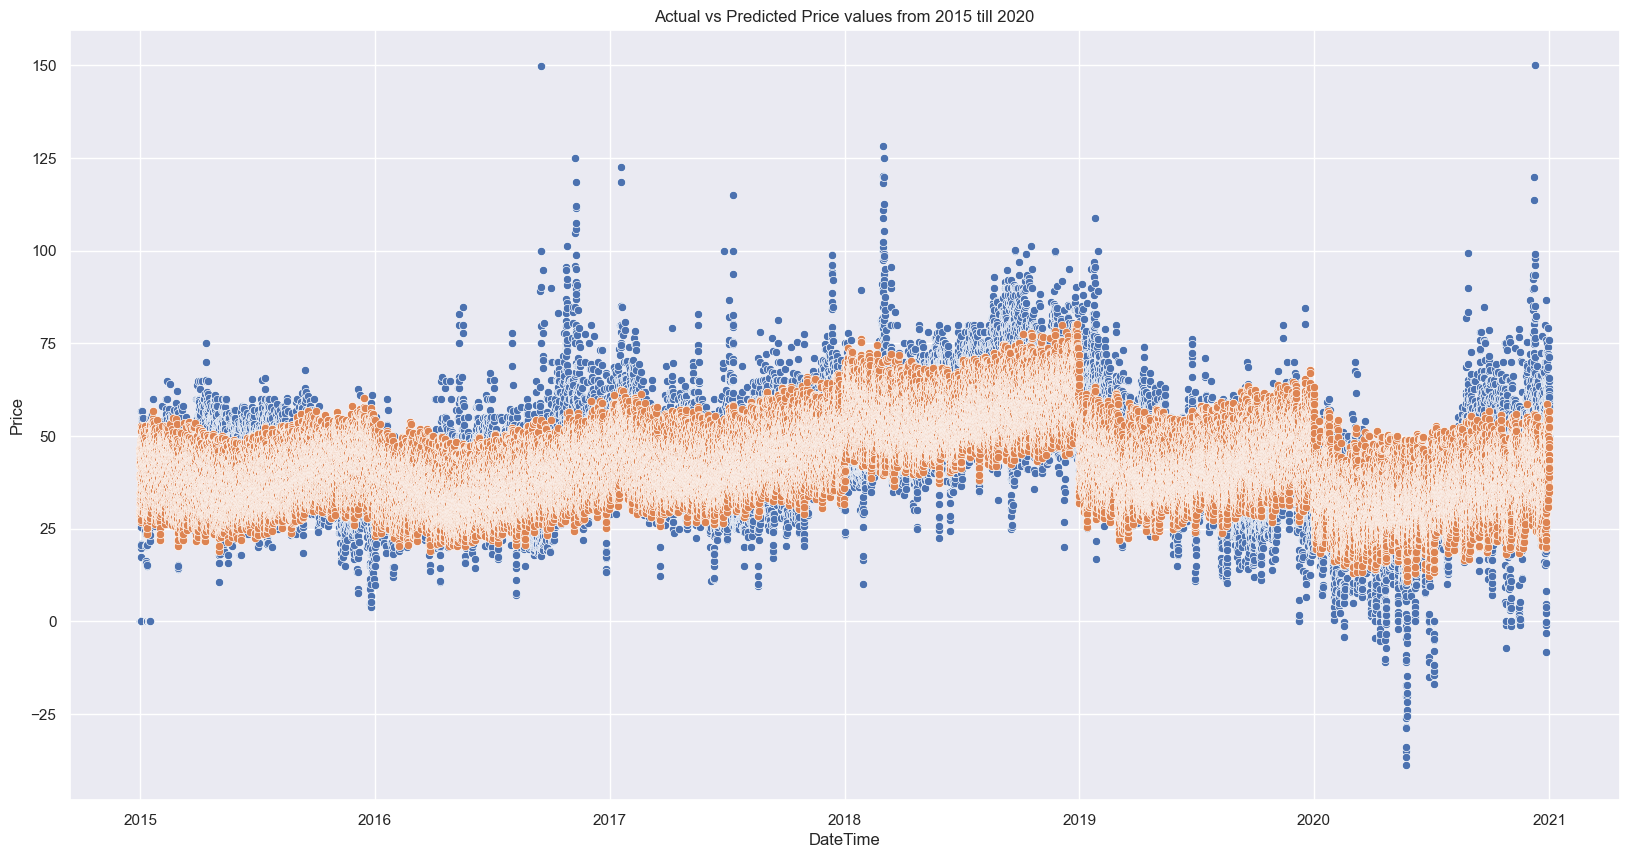

In [23]:
fig, ax = plt.subplots()
sns.scatterplot(x = df_model_1.index , y='Price' , data=df_model_1, ax=ax)
sns.scatterplot(x = df_model_1.index, y='Price_pred', data=df_model_1, ax=ax)
plt.title('Actual vs Predicted Price values from 2015 till 2020')

C:\Users\2836589S\AppData\Local\Temp\ipykernel_26464\2918457691.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model_1['Price_Residuals'] = df_model_1['Price'] - df_model_1['Price_pred']


Text(0.5, 1.0, 'Scatterplot of residuals')

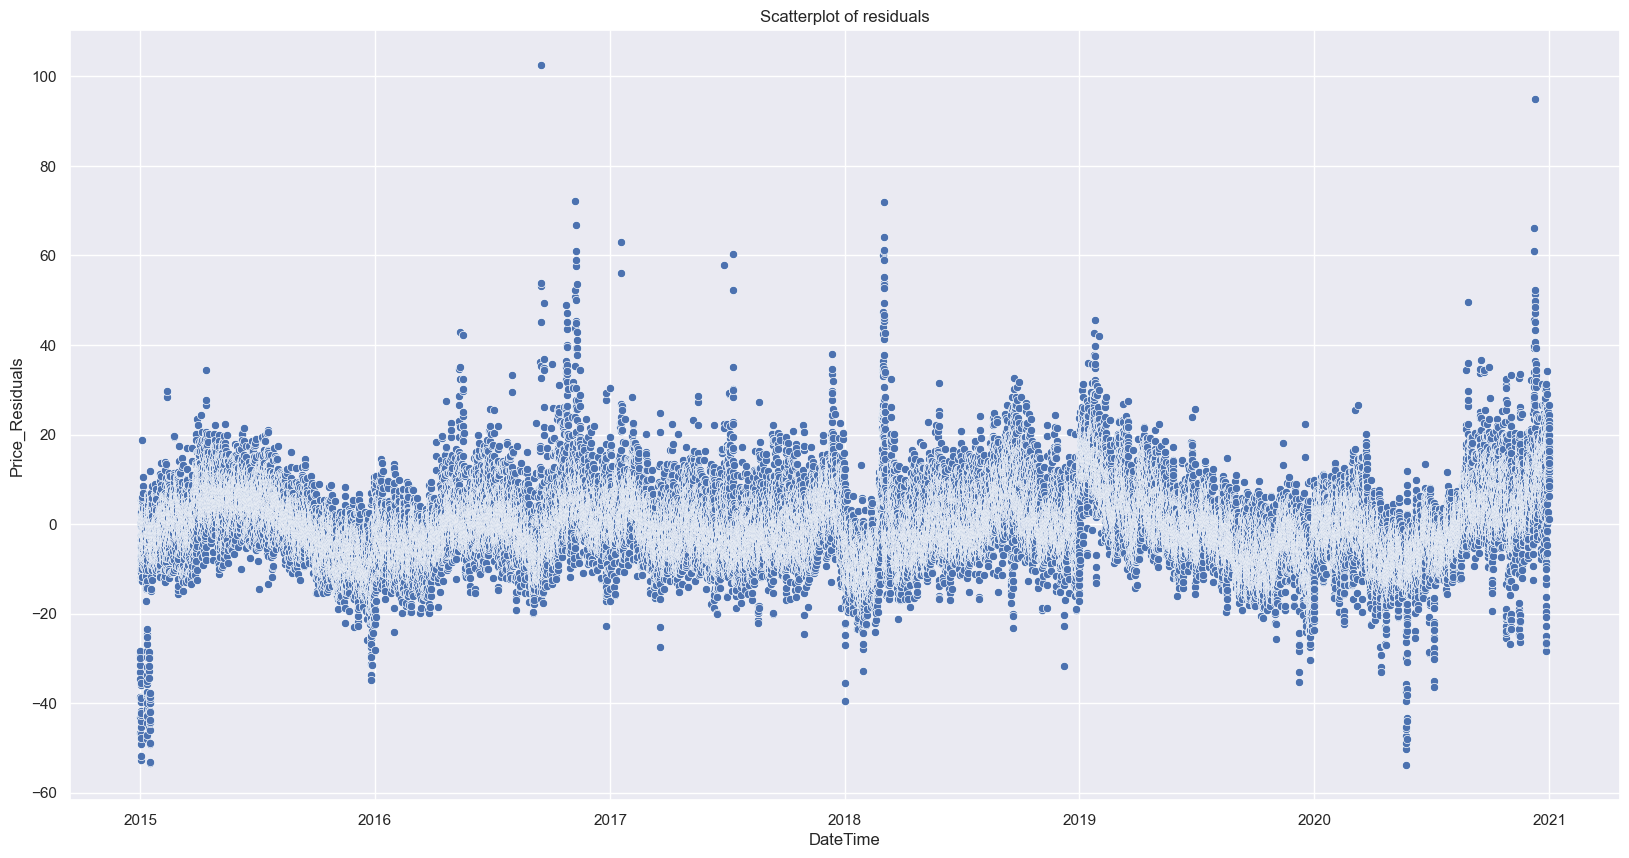

In [24]:
df_model_1['Price_Residuals'] = df_model_1['Price'] - df_model_1['Price_pred']
sns.scatterplot(x=df_model_1.index, y='Price_Residuals', data=df_model_1, palette='flare')
plt.title("Scatterplot of residuals")